### Análise Exploratória de Dados do Dataset BNAFAR

---


Dados: https://opendatasus.saude.gov.br/dataset/bnafar-posicao-de-estoque

### Descrição do Dataset — Posição de Estoque (BNAFAR)

O conjunto de dados **Posição de Estoque** faz parte da **Base Nacional de Dados de Ações e Serviços da Assistência Farmacêutica (BNAFAR)**, mantida pelo Ministério da Saúde. Ele representa o retrato detalhado do **estoque de medicamentos e insumos de saúde** existentes em estabelecimentos vinculados ao **Cadastro Nacional de Estabelecimentos de Saúde (CNES)**, em uma determinada **data de posição de estoque**.  
Cada linha do dataset corresponde à **quantidade de um produto específico (identificado por código CATMAT)**, associado a um **lote** e **data de validade**, mantido em um **estabelecimento de saúde** identificado por seu código **CNES**, município e unidade federativa (UF). O conjunto traz ainda informações complementares sobre o estabelecimento — razão social, nome fantasia, endereço, CEP, telefone, e-mail e coordenadas geográficas —, permitindo análises espaciais e operacionais.  
Os produtos são classificados segundo o **tipo de componente da Assistência Farmacêutica** (Básico, Especializado, Estratégico ou Outros) e vinculados a programas de saúde específicos. Além disso, o campo **SG_ORIGEM** identifica o sistema de onde os dados foram originados (como o **Hórus** ou serviços **SOA/WSBNDAF**).  
Esse dataset é essencial para o **monitoramento do abastecimento e da disponibilidade de medicamentos** no SUS, oferecendo subsídios para políticas públicas de gestão de estoque, distribuição e planejamento farmacêutico em nível municipal, estadual e federal.


###  Dicionário de Dados — Posição de Estoque (comparação CSV × Dicionário)

A tabela abaixo mostra o mapeamento entre os nomes das colunas do arquivo `Posicao_Estoque_06-05-2025.csv`
e o dicionário oficial de dados da Posição de Estoque (BNAFAR).  
As diferenças de nome ou formato estão destacadas com ⚠️.

| **Coluna no CSV** | **Coluna no Dicionário** | **Diferença / Observação** |
|--------------------|---------------------------|-----------------------------|
| `sg_uf` | `SG_UF` | ✅ equivalente (mesmo nome, só difere em maiúsculas). |
| `co_municipio_ibge` | `CO_MUNICIPIO_IBGE` | ✅ equivalente. |
| `no_municipio` | `NO_MUNICIPIO` | ✅ equivalente. |
| `co_cnes` | `CO_CNES` | ✅ equivalente. |
| `no_razao_social` | `NOME_RAZAO_SOCIAL` | ⚠️ nome diferente, mas mesmo conceito. |
| `no_fantasia` | `NOME_FANTASIA` | ⚠️ nome diferente, mesmo conceito. |
| `co_cep` | `CODIGO_CEP_ESTABELECIMENTO` | ⚠️ nome diferente; no CSV veio como número com `.0` (ex: `76954000.0`). |
| `no_logradouro` | `ENDERECO_ESTABELECIMENTO` | ⚠️ nome diferente, mesmo conceito. |
| `nu_endereco` | `NUMERO_ESTABELECIMENTO` | ⚠️ nome diferente, mesmo conceito. |
| `no_bairro` | `BAIRRO_ESTABELECIMENTO` | ⚠️ nome diferente, mesmo conceito. |
| `dt_posicao_estoque` | `DT_POSICAO_ESTOQUE` | ✅ equivalente; no CSV o formato é `YYYY/MM/DD`. |
| `co_catmat` | `CO_CATMAT` | ✅ equivalente. |
| `ds_produto` | `DS_PRODUTO` | ✅ equivalente. |
| `qt_estoque` | `QT_ITENS` | ⚠️ nome diferente; no CSV usa vírgula como separador decimal (`"3,0"`). |
| `nu_lote` | `NU_LOTE` | ✅ equivalente. |
| `dt_validade` | `DT_VALIDADE` | ✅ equivalente; contém fuso horário (`-03`). |
| `tp_produto` | `TP_PRODUTO` | ✅ equivalente. |
| `sg_programa_saude` | `SG_PROGRAMA_SAUDE` | ✅ equivalente. |
| `ds_programa_saude` | `DS_PROGRAMA_SAUDE` | ✅ equivalente. |
| `sg_origem` | `SG_ORIGEM` | ✅ equivalente (ex: HORUS, WSBNDAF). |


## Início da Análise

In [ ]:
# importações

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from tabulate import tabulate
from google.colab import drive
import numpy as np
import seaborn as sns
import sqlite3
import glob
import os
import duckdb

In [ ]:
### vamos passar o nome de cada arquivo dinamicamente

#dados 2025
data_06_04_2025 = "Posicao_Estoque_06-04-2025.csv" #1
data_06_05_2025 = "Posicao_Estoque_06-05-2025.csv" #2
data_21_04_2025 = "Posicao_Estoque_21-04-2025.csv" #3
data_21_05_2025 = "Posicao_Estoque_21-05-2025.csv" #4
data_06_10_2025 = "Posicao_Estoque_06-10-2025.csv" #5


#dados 2024
data_06_10_2024 = "Posicao_Estoque_06-10-2024.csv" #6
data_06_11_2024 = "Posicao_Estoque_06-11-2024.csv" #7
data_21_12_2024 = "Posicao_Estoque_21-12-2024.csv" #8

In [ ]:
### Aqui vamos importar diretamente do google drive

## link do drive:
# https://drive.google.com/drive/folders/1xIhOhihE8GlxhfA7cSvvtzN_CIk78-09?hl=pt-br

## precisa aceitar a verificação

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## vamos especificar qual csv queremos analisar (procurando ele dentro do drive)

# variavel que vamos modificar:

v = data_21_05_2025   ### mude aqui a data desejada <-----------------------

arquivo = '/content/drive/MyDrive/EDA-BNAFAR/'+ v
print(arquivo)

/content/drive/MyDrive/EDA-BNAFAR/Posicao_Estoque_21-05-2025.csv


In [ ]:

import pandas as pd

## as vezes dá erro nos arquivos maiores: A sessão falhou depois de usar toda a RAM disponível.


# Lê o CSV inteiro - pode demorar um pouco para rodar ~2min (faz o fetch do drive)
df = pd.read_csv(
    arquivo,
    sep=";",
    encoding="latin1",
    low_memory=False
)

# Conta valores faltantes
missing_counts = df.isna().sum().sort_values(ascending=False)

# Número total de linhas (seguro)
total = len(df)

print("Resultado: \n")
for col, count in missing_counts.items():
        pct = (count / total) * 100
        print(f"{col}: {count} ({pct:.2f}%) valores ausentes")

print(f"\nTotal de linhas analisadas: {total:,}")

Resultado: 

no_email: 2463502 (45.86%) valores ausentes
nu_telefone: 1360472 (25.33%) valores ausentes
nu_latitude: 154531 (2.88%) valores ausentes
nu_longitude: 153612 (2.86%) valores ausentes
nu_endereco: 119606 (2.23%) valores ausentes
no_logradouro: 119084 (2.22%) valores ausentes
no_fantasia: 119084 (2.22%) valores ausentes
co_cep: 119084 (2.22%) valores ausentes
no_razao_social: 119084 (2.22%) valores ausentes
no_bairro: 119084 (2.22%) valores ausentes
nu_lote: 3026 (0.06%) valores ausentes
sg_programa_saude: 54 (0.00%) valores ausentes
sg_uf: 0 (0.00%) valores ausentes
co_municipio_ibge: 0 (0.00%) valores ausentes
no_municipio: 0 (0.00%) valores ausentes
co_cnes: 0 (0.00%) valores ausentes
co_catmat: 0 (0.00%) valores ausentes
dt_posicao_estoque: 0 (0.00%) valores ausentes
qt_estoque: 0 (0.00%) valores ausentes
ds_produto: 0 (0.00%) valores ausentes
dt_validade: 0 (0.00%) valores ausentes
tp_produto: 0 (0.00%) valores ausentes
ds_programa_saude: 0 (0.00%) valores ausentes
sg_or

In [ ]:
total_original = sum(1 for _ in open(arquivo, encoding="latin1"))
print("Total de linhas no arquivo:", total_original)
print("Linhas lidas no DataFrame:", len(df))
print("Linhas ignoradas:", total_original - len(df))

Total de linhas no arquivo: 5371993
Linhas lidas no DataFrame: 5371992
Linhas ignoradas: 1


In [ ]:
#Analise de variaveis
cat_cols = df.select_dtypes(include='object').columns

for col in cat_cols:
    print(f"\n--- {col} ---")
    print(df[col].value_counts(normalize=True).head(10)) #imprime a proporção dos valores presentes nas colunas type=object
                                                         #manipulando o .head() alteramos a quantidade de elementos impressos por coluna



--- sg_uf ---
sg_uf
CE    0.137533
SP    0.113338
BA    0.095769
PE    0.080148
AL    0.079899
GO    0.057507
MT    0.057016
PA    0.053350
RN    0.044578
PB    0.030718
Name: proportion, dtype: float64

--- no_municipio ---
no_municipio
Maceió          0.021757
Natal           0.013815
Belém           0.012631
Araraquara      0.011574
Campo Grande    0.008578
Teresina        0.007445
Vila Velha      0.006702
Paulínia        0.006644
Maricá          0.006586
Carapicuíba     0.006488
Name: proportion, dtype: float64

--- no_razao_social ---
no_razao_social
SECRETARIA MUNICIPAL DE SAUDE             0.033480
FUNDO MUNICIPAL DE SAUDE                  0.010574
PREFEITURA MUNICIPAL DE ARARAQUARA        0.009142
MUNICIPIO DE CAMPO GRANDE                 0.008103
PREFEITURA MUNICIPAL DE PAULINIA          0.006430
PREFEITURA MUNICIPAL DE CARAPICUIBA       0.006307
SECRETARIA MUNICIPAL DE SAUDE DE BELEM    0.006099
MUNICIPAL DE VILA VELHA                   0.006045
MUNICIPIO DE MARICA          

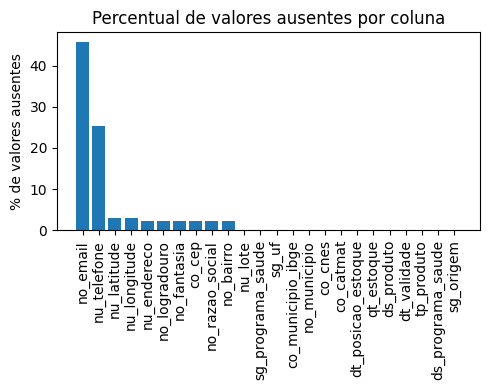

In [ ]:

# Calcula percentual de nulos por coluna
missing_percent = (missing_counts / total) * 100
missing_percent = missing_percent.sort_values(ascending=False)
# Cria figura
plt.figure(figsize=(5, 4))
plt.bar(missing_percent.index, missing_percent.values)
plt.xticks(rotation=90)
plt.ylabel('% de valores ausentes')
plt.title('Percentual de valores ausentes por coluna')
plt.tight_layout()
plt.show()


In [ ]:
# Uma linha aleatória
n = 5
linha = df.sample(n)

print("Imprimir",n,"linhas aleatórias do csv \n")
# Tabela formatada bonitinha
print(tabulate(linha, headers="keys", tablefmt="fancy_grid", showindex=False))

Imprimir 5 linhas aleatórias do csv 

╒═════════╤═════════════════════╤═════════════════════════╤═══════════╤═══════════════════════════════════════╤════════════════════════════════════════════════╤═════════════╤═════════════════════════════════╤═══════════════╤═════════════╤════════════════╤═══════════════╤════════════════╤════════════════════╤══════════════════════╤════════════════╤══════════════════════════════════════════════════════════════════════╤══════════════╤═══════════╤════════════════════════╤══════════════╤═════════════════════╤══════════════════════════╤═════════════╕
│ sg_uf   │   co_municipio_ibge │ no_municipio            │   co_cnes │ no_razao_social                       │ no_fantasia                                    │      co_cep │ no_logradouro                   │ nu_endereco   │ no_bairro   │ nu_telefone    │   nu_latitude │   nu_longitude │ no_email           │ dt_posicao_estoque   │ co_catmat      │ ds_produto                                                   

In [ ]:
# normaliza o texto da coluna
df['no_municipio'] = df['no_municipio'].astype(str).str.strip().str.lower()

# tokens considerados inválidos
tokens_invalidos = {"", "nan", "na", "n/a", "none", "null", "s/n", "sn", "-", "--", ".", "..."}

# cria máscara de linhas suspeitas
mask = (
    df['no_municipio'].isin(tokens_invalidos)
    | df['no_municipio'].str.fullmatch(r'\d+', na=False)
    | df['no_municipio'].str.fullmatch(r'[^a-zA-ZÀ-ÿ]+', na=False)
)

# filtra e pega 10 linhas aleatórias
n = 10
amostra = df[mask].sample(n=min(n, df[mask].shape[0]), random_state=42)

print(f"Imprimir {len(amostra)} linhas aleatórias onde 'no_municipio' parece inválido:\n")
print(tabulate(amostra, headers="keys", tablefmt="fancy_grid", showindex=False))

Imprimir 0 linhas aleatórias onde 'no_municipio' parece inválido:

╒═════════╤═════════════════════╤════════════════╤═══════════╤═══════════════════╤═══════════════╤══════════╤═════════════════╤═══════════════╤═════════════╤═══════════════╤═══════════════╤════════════════╤════════════╤══════════════════════╤═════════════╤══════════════╤══════════════╤═══════════╤═══════════════╤══════════════╤═════════════════════╤═════════════════════╤═════════════╕
│ sg_uf   │ co_municipio_ibge   │ no_municipio   │ co_cnes   │ no_razao_social   │ no_fantasia   │ co_cep   │ no_logradouro   │ nu_endereco   │ no_bairro   │ nu_telefone   │ nu_latitude   │ nu_longitude   │ no_email   │ dt_posicao_estoque   │ co_catmat   │ ds_produto   │ qt_estoque   │ nu_lote   │ dt_validade   │ tp_produto   │ sg_programa_saude   │ ds_programa_saude   │ sg_origem   │
╞═════════╪═════════════════════╪════════════════╪═══════════╪═══════════════════╪═══════════════╪══════════╪═════════════════╪═══════════════╪═════════════╪

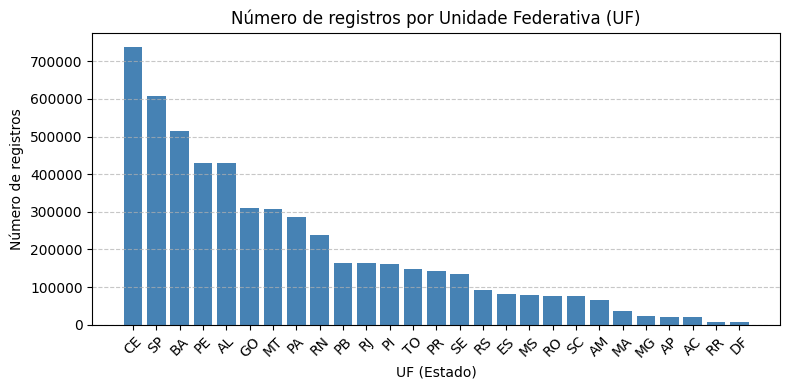

In [ ]:
# Agrupa e conta registros por estado
uf_counts = df["sg_uf"].value_counts().sort_values(ascending=False)

# Cria o histograma (barras)
plt.figure(figsize=(8, 4))
plt.bar(uf_counts.index, uf_counts.values, color="steelblue")

# Adiciona rótulos e título
plt.title("Número de registros por Unidade Federativa (UF)")
plt.xlabel("UF (Estado)")
plt.ylabel("Número de registros")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)


plt.tight_layout()
plt.show()

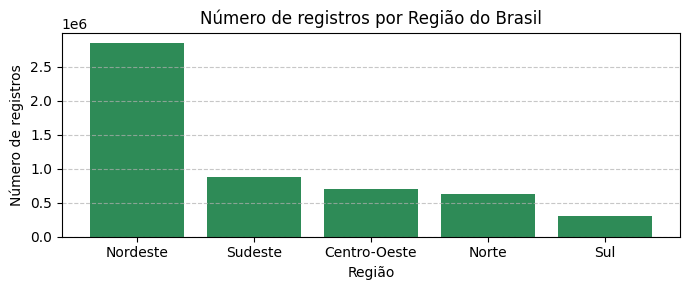

In [ ]:

# Dicionário de mapeamento: UF → Região
regioes = {
    "AC": "Norte", "RO": "Norte", "AM": "Norte", "RR": "Norte", "AP": "Norte", "PA": "Norte", "TO": "Norte",
    "MA": "Nordeste", "PI": "Nordeste", "CE": "Nordeste", "BA": "Nordeste", "SE": "Nordeste",
    "AL": "Nordeste", "PE": "Nordeste", "PB": "Nordeste", "RN": "Nordeste",
    "MT": "Centro-Oeste", "GO": "Centro-Oeste", "MS": "Centro-Oeste", "DF": "Centro-Oeste",
    "MG": "Sudeste", "ES": "Sudeste", "SP": "Sudeste", "RJ": "Sudeste",
    "PR": "Sul", "SC": "Sul", "RS": "Sul"
}

# Cria uma série temporária com as regiões correspondentes
regioes_mapeadas = df["sg_uf"].map(regioes)

# Conta quantos registros há por região
regiao_counts = regioes_mapeadas.value_counts().sort_values(ascending=False)

# Cria o gráfico de barras
plt.figure(figsize=(7, 3))
plt.bar(regiao_counts.index, regiao_counts.values, color="seagreen")

# Adiciona rótulos e título
plt.title("Número de registros por Região do Brasil")
plt.xlabel("Região")
plt.ylabel("Número de registros")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


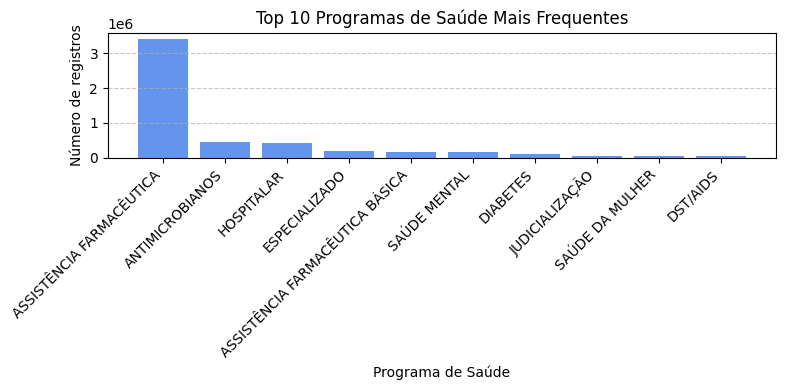

In [ ]:

# Conta o número de registros e seleciona os 10 mais frequentes
programa_counts = df["ds_programa_saude"].value_counts().head(10)

# Cria o gráfico de barras
plt.figure(figsize=(8, 4))
plt.bar(programa_counts.index, programa_counts.values, color="cornflowerblue")

# Adiciona rótulos e título
plt.title("Top 10 Programas de Saúde Mais Frequentes")
plt.xlabel("Programa de Saúde")
plt.ylabel("Número de registros")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


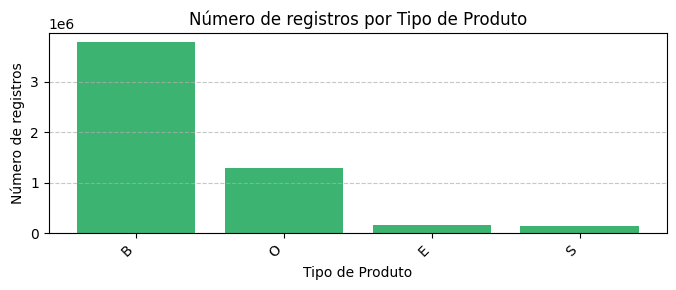


 Sigla do Tipo de Produto em Estoque:

B – Produtos do Componente Básico da Assistência Farmacêutica
    (Anexos I e IV da RENAME);

E – Produtos do Componente Especializado da Assistência Farmacêutica
    (Anexo III da RENAME);

S – Produtos do Componente Estratégico da Assistência Farmacêutica
    (Anexos II e IV da RENAME);

O – Produtos financiados somente com recursos próprios do ente.



In [ ]:
# Conta o número de registros por tipo de produto
produto_counts = df["tp_produto"].value_counts().sort_values(ascending=False)

# Cria o gráfico de barras
plt.figure(figsize=(7, 3))
plt.bar(produto_counts.index, produto_counts.values, color="mediumseagreen")

# Adiciona rótulos e título
plt.title("Número de registros por Tipo de Produto")
plt.xlabel("Tipo de Produto")
plt.ylabel("Número de registros")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()
print("""
 Sigla do Tipo de Produto em Estoque:

B – Produtos do Componente Básico da Assistência Farmacêutica
    (Anexos I e IV da RENAME);

E – Produtos do Componente Especializado da Assistência Farmacêutica
    (Anexo III da RENAME);

S – Produtos do Componente Estratégico da Assistência Farmacêutica
    (Anexos II e IV da RENAME);

O – Produtos financiados somente com recursos próprios do ente.
""")

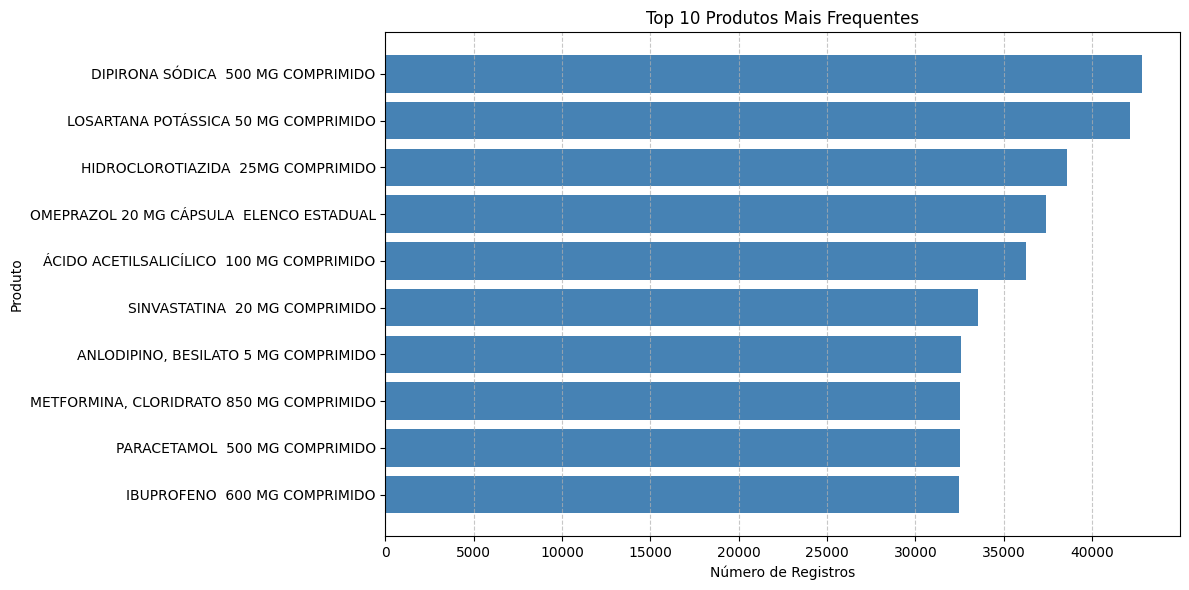

In [ ]:
# Conta o número de registros e seleciona os 20 mais frequentes
produto_counts = df["ds_produto"].value_counts().head(10)

# Cria o gráfico de barras
plt.figure(figsize=(12, 6))
plt.barh(produto_counts.index[::-1], produto_counts.values[::-1], color="steelblue")  # invertido p/ o mais frequente no topo

# Adiciona rótulos e título
plt.title("Top 10 Produtos Mais Frequentes")
plt.xlabel("Número de Registros")
plt.ylabel("Produto")
plt.grid(axis="x", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

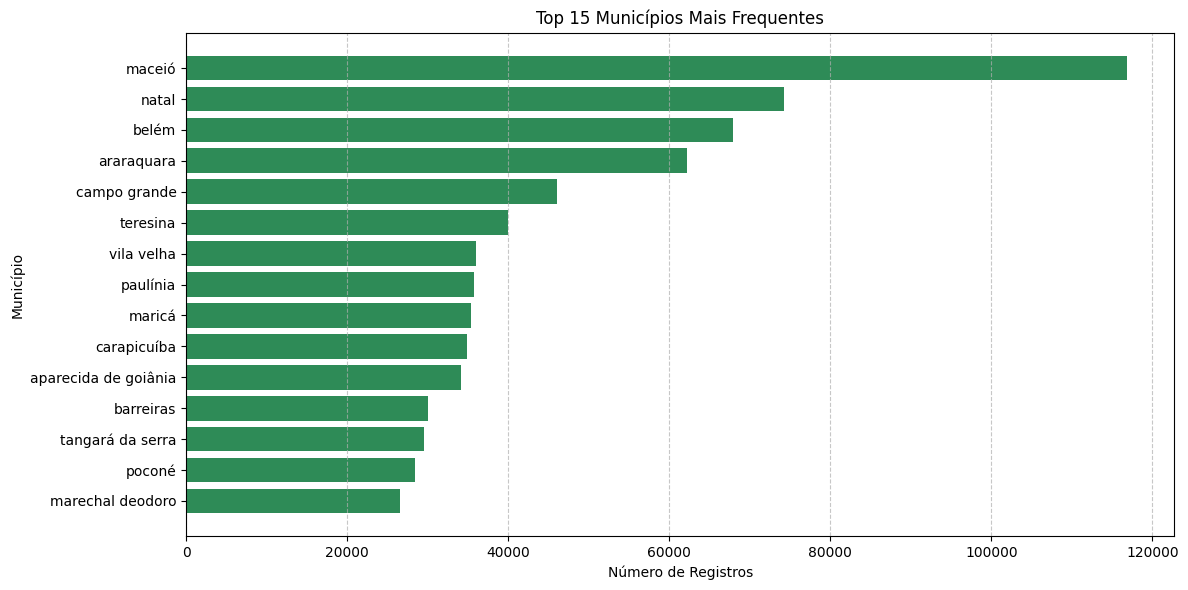

In [ ]:
#Municípios mais frequentes
municipio_counts = df["no_municipio"].value_counts().head(15)

# Cria o gráfico de barras
plt.figure(figsize=(12, 6))
plt.barh(municipio_counts.index[::-1], municipio_counts.values[::-1], color="seagreen")

# Adiciona rótulos e título
plt.title("Top 15 Municípios Mais Frequentes")
plt.xlabel("Número de Registros")
plt.ylabel("Município")
plt.grid(axis="x", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

# recortes espaciais

In [ ]:
!pip install sidrapy geobr geopandas shapely matplotlib --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.0/338.0 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 80.7 MB/s eta 0:00:00


In [ ]:
!pip install mapclassify --quiet

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from geobr import read_state

In [ ]:
uf_counts = df["sg_uf"].value_counts().sort_values(ascending=False)
df_uf = uf_counts.to_frame(name='total_registros').reset_index()
df_uf.head(26)

,sg_uf,total_registros
0,CE,738824
1,SP,608853
2,BA,514472
3,PE,430552
4,AL,429219
5,GO,308927
6,MT,306289
7,PA,286594
8,RN,239473
9,PB,165016


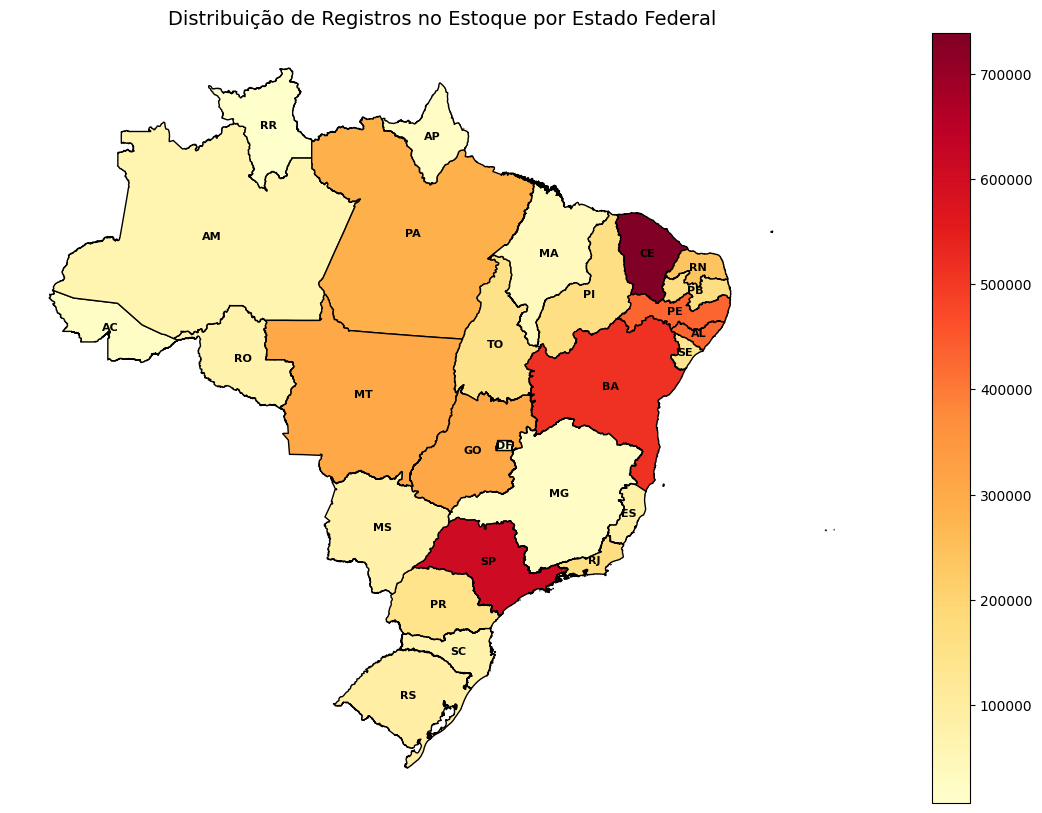

In [ ]:

# Lê geometrias dos estados do Brasil
gdf_brasil = read_state()  # retorna GeoDataFrame com geometria dos estados

# Junta df_uf
gdf_merged = gdf_brasil.merge(df_uf, left_on="abbrev_state", right_on="sg_uf")

# Plotagem estilo heatmap
gdf_merged.plot(
    column="total_registros",
    cmap="YlOrRd",
    legend=True,
    figsize=(15, 10),
    edgecolor="black"
)

plt.title("Distribuição de Registros no Estoque por Estado Federal", fontsize=14)
plt.axis("off")

for idx, row in gdf_merged.iterrows():
    plt.text(
        row.geometry.centroid.x,
        row.geometry.centroid.y,
        row["abbrev_state"],
        ha='center', va='center',
        fontsize=8, fontweight='bold', color='black'
    )

plt.show()


In [ ]:
df_ibge = pd.read_excel("/content/drive/MyDrive/EDA-BNAFAR/estimativa_dou_2025.xls")
df_ibge.head(10)

,ESTIMATIVAS DA POPULAÇÃO RESIDENTE NO BRASIL E UNIDADES DA FEDERAÇÃO COM DATA DE REFERÊNCIA EM 1º DE JULHO DE 2025,Unnamed: 1,Unnamed: 2
0,BRASIL E UNIDADES DA FEDERAÇÃO,POPULAÇÃO ESTIMADA,NaN
1,Brasil,213421037,NaN
2,Norte,18801282,NaN
3,Rondônia,1751950,NaN
4,Acre,884372,NaN
5,Amazonas,4321616,NaN
6,Roraima,738772,NaN
7,Pará,8711196,NaN
8,Amapá,806517,NaN
9,Tocantins,1586859,NaN


In [ ]:
df_pop_geral = df_ibge.groupby('ESTIMATIVAS DA POPULAÇÃO RESIDENTE NO BRASIL E UNIDADES DA FEDERAÇÃO COM DATA DE REFERÊNCIA EM 1º DE JULHO DE 2025')['Unnamed: 1'].sum()
df_pop_geral = df_pop_geral.to_frame(name='populacao').reset_index()

In [ ]:
df_pop_geral.head()


,ESTIMATIVAS DA POPULAÇÃO RESIDENTE NO BRASIL E UNIDADES DA FEDERAÇÃO COM DATA DE REFERÊNCIA EM 1º DE JULHO DE 2025,populacao
0,(1) diferença de 67 pessoas entre os Estados ...,0
1,Nota:,0
2,Acre,884372
3,Alagoas,3220848
4,Amapá,806517


In [ ]:
# Tratamento do dataframe ibge para o formato sg_uf -> população
ufs_extenso = [
    "Acre",
    "Alagoas",
    "Amapá",
    "Amazonas",
    "Bahia",
    "Ceará",
    "Distrito Federal",
    "Espírito Santo",
    "Goiás",
    "Maranhão",
    "Mato Grosso",
    "Mato Grosso do Sul",
    "Minas Gerais",
    "Pará",
    "Paraíba",
    "Paraná",
    "Pernambuco",
    "Piauí",
    "Rio de Janeiro",
    "Rio Grande do Norte",
    "Rio Grande do Sul",
    "Rondônia",
    "Roraima",
    "Santa Catarina",
    "São Paulo",
    "Sergipe",
    "Tocantins"
]

uf_pop = df_pop_geral[df_pop_geral['ESTIMATIVAS DA POPULAÇÃO RESIDENTE NO BRASIL E UNIDADES DA FEDERAÇÃO COM DATA DE REFERÊNCIA EM 1º DE JULHO DE 2025'].isin(ufs_extenso)]
uf_pop = uf_pop.rename(columns={'ESTIMATIVAS DA POPULAÇÃO RESIDENTE NO BRASIL E UNIDADES DA FEDERAÇÃO COM DATA DE REFERÊNCIA EM 1º DE JULHO DE 2025': "unidade_federal"})


# mapeamento de nome completo do estado → sigla UF

nome_para_sigla = {
    "Acre": "AC",
    "Alagoas": "AL",
    "Amapá": "AP",
    "Amazonas": "AM",
    "Bahia": "BA",
    "Ceará": "CE",
    "Distrito Federal": "DF",
    "Espírito Santo": "ES",
    "Goiás": "GO",
    "Maranhão": "MA",
    "Mato Grosso": "MT",
    "Mato Grosso do Sul": "MS",
    "Minas Gerais": "MG",
    "Pará": "PA",
    "Paraíba": "PB",
    "Paraná": "PR",
    "Pernambuco": "PE",
    "Piauí": "PI",
    "Rio de Janeiro": "RJ",
    "Rio Grande do Norte": "RN",
    "Rio Grande do Sul": "RS",
    "Rondônia": "RO",
    "Roraima": "RR",
    "Santa Catarina": "SC",
    "São Paulo": "SP",
    "Sergipe": "SE",
    "Tocantins": "TO"
}

uf_pop["unidade_federal"] = uf_pop["unidade_federal"].map(nome_para_sigla)

uf_pop.head(28)

,unidade_federal,populacao
2,AC,884372
3,AL,3220848
4,AP,806517
5,AM,4321616
7,BA,14870907
9,CE,9268836
11,DF,2996899
12,ES,4126854
14,GO,7423629
15,MA,7018211


In [ ]:
#prepara o dataframe cruzado entre ocorrencia de ufs do bnafar e os valores populacionais disponibilizados pelo ibge

# 1️ Faz o merge unindo pelas siglas de estado
df_merge = df_uf.merge(uf_pop, left_on="sg_uf", right_on="unidade_federal")

# 2️ Calcula a razão: n° d eregistros / população do Estado
df_merge["reg_por_hab"] = (df_merge["total_registros"] / df_merge["populacao"]) * 1000

# 3️ (opcional) Ordena do maior para o menor
df_reg_por_pop = df_merge.sort_values("reg_por_hab", ascending=False)

# 4️ Exibe
display(df_reg_por_pop[["sg_uf", "total_registros", "populacao", "reg_por_hab"]])


,sg_uf,total_registros,populacao,reg_por_hab
4,AL,429219,3220848,133.262731
12,TO,147929,1586859,93.221263
0,CE,738824,9268836,79.710548
6,MT,306289,3893659,78.66354
8,RN,239473,3455236,69.307277
14,SE,135889,2299425,59.096948
11,PI,162303,3384547,47.954128
3,PE,430552,9562007,45.027367
18,RO,75497,1751950,43.093125
5,GO,308927,7423629,41.614014


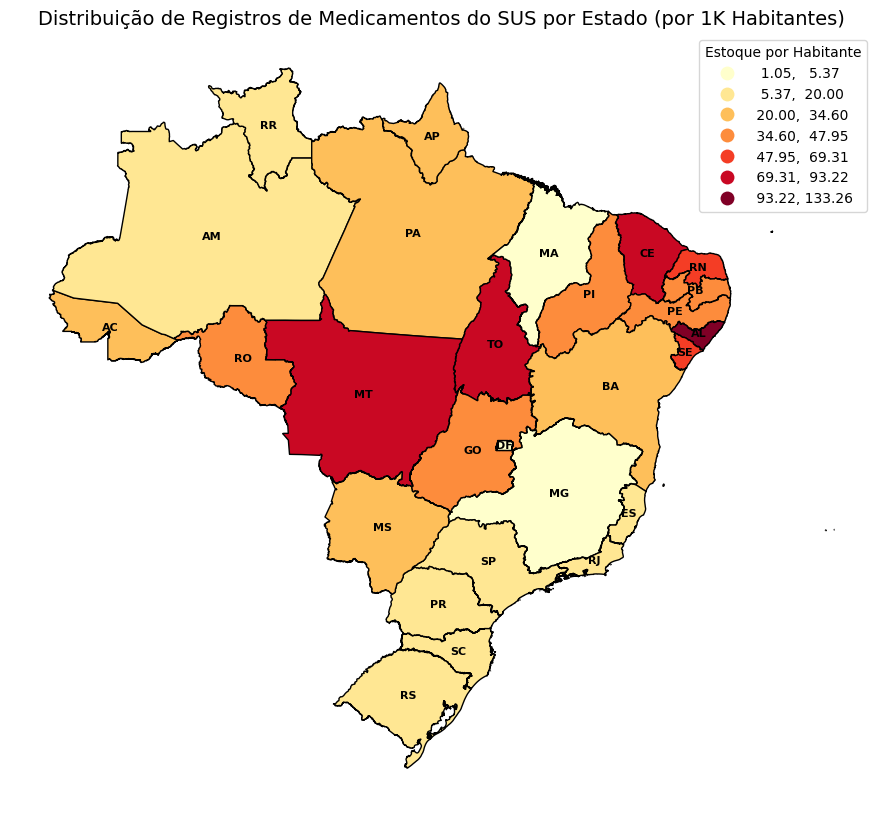

In [ ]:

# Lê geometrias dos estados do Brasil
gdf_brasil = read_state()  # retorna GeoDataFrame com geometria dos estados

# Junta df_uf
gdf_merged = gdf_brasil.merge(df_reg_por_pop, left_on="abbrev_state", right_on="sg_uf")

# Plotagem estilo heatmap
gdf_merged.plot(
    column="reg_por_hab",
    cmap="YlOrRd",
    legend=True,
    figsize=(15, 10),
    edgecolor="black",

    scheme="natural_breaks",  # ou "quantiles"
    k=7,                      # Número de classes (7 é um bom número)
    legend_kwds={
        'title': "Estoque por Habitante",
        'loc': 'upper right',
         'fmt': '{:.2f}'
    }
)

plt.title("Distribuição de Registros de Medicamentos do SUS por Estado (por 1K Habitantes)", fontsize=14)
plt.axis("off")

for idx, row in gdf_merged.iterrows():
    plt.text(
        row.geometry.centroid.x,
        row.geometry.centroid.y,
        row["abbrev_state"],
        ha='center', va='center',
        fontsize=8, fontweight='bold', color='black'
    )

plt.show()

In [ ]:
#Programa de saude mais frquente em cada Estado
df_filtro = df[df['ds_programa_saude'] != 'ASSISTÊNCIA FARMACÊUTICA']

df_programas_uf = (
    df_filtro.groupby('sg_uf')['ds_programa_saude']
      .agg(lambda x: x.mode().iloc[0])  # pega o mais frequente
      .reset_index()
)

df_programas_uf.head(28)

,sg_uf,ds_programa_saude
0,AC,ANTIMICROBIANOS
1,AL,HOSPITALAR
2,AM,ANTIMICROBIANOS
3,AP,ESPECIALIZADO
4,BA,ANTIMICROBIANOS
5,CE,ESPECIALIZADO
6,DF,ESPECIALIZADO
7,ES,HOSPITALAR
8,GO,HOSPITALAR
9,MA,ANTIMICROBIANOS


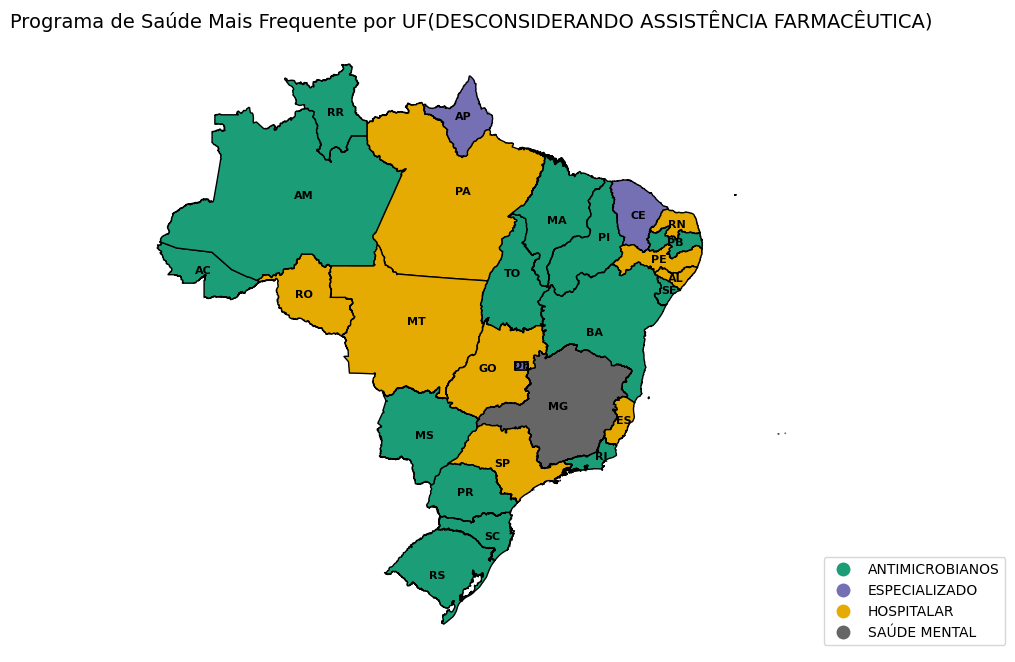

In [ ]:

# Lê geometrias dos estados do Brasil
gdf_brasil = read_state()  # retorna GeoDataFrame com geometria dos estados

# Junta df_uf
gdf_merged = gdf_brasil.merge(df_programas_uf, left_on="abbrev_state", right_on="sg_uf")

fig, ax = plt.subplots(figsize=(12, 8))
gdf_merged.plot(
    column='ds_programa_saude',
    cmap='Dark2',
    categorical=True,
    legend=True,
    legend_kwds={'loc': 'lower left', 'bbox_to_anchor': (1, 0)},
    ax=ax,
    edgecolor='black'
)

plt.title("Programa de Saúde Mais Frequente por UF(DESCONSIDERANDO ASSISTÊNCIA FARMACÊUTICA)", fontsize=14)
plt.axis("off")

for idx, row in gdf_merged.iterrows():
    x, y = row.geometry.representative_point().x, row.geometry.representative_point().y
    plt.text(x, y, row["sg_uf"], ha='center', va='center', fontsize=8, fontweight='bold')

plt.show()

In [ ]:
#Programa de saude mais frquente em cada Estado
df_medicamento_uf = (
    df.groupby('sg_uf')['ds_produto']
      .agg(lambda x: x.mode().iloc[0])  # pega o mais frequente
      .reset_index()
)

df_medicamento_uf.head(28)

,sg_uf,ds_produto
0,AC,DIPIRONA SÓDICA 500 MG COMPRIMIDO
1,AL,"METFORMINA, CLORIDRATO 850 MG COMPRIMIDO"
2,AM,"METFORMINA, CLORIDRATO 850 MG COMPRIMIDO"
3,AP,LOSARTANA POTÁSSICA 50 MG COMPRIMIDO
4,BA,LOSARTANA POTÁSSICA 50 MG COMPRIMIDO
5,CE,"METFORMINA, CLORIDRATO 500 MG COMPRIMIDO"
6,DF,"FLUOXETINA, CLORIDRATO 20 MG CÁPSULA ELENCO E..."
7,ES,DIPIRONA SÓDICA 500 MG COMPRIMIDO
8,GO,DIPIRONA SÓDICA 500 MG COMPRIMIDO
9,MA,"METFORMINA, CLORIDRATO 850 MG COMPRIMIDO"


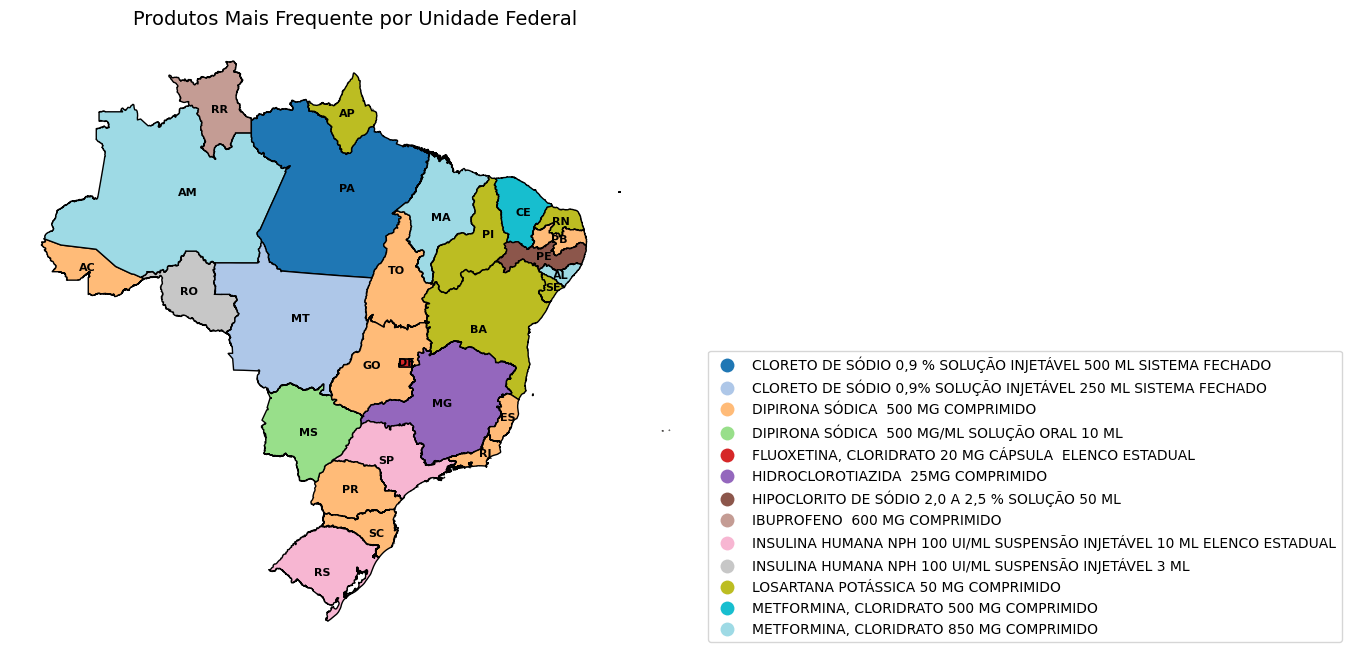

In [ ]:

# Lê geometrias dos estados do Brasil
gdf_brasil = read_state()  # retorna GeoDataFrame com geometria dos estados

# Junta df_uf
gdf_merged = gdf_brasil.merge(df_medicamento_uf, left_on="abbrev_state", right_on="sg_uf")

fig, ax = plt.subplots(figsize=(12, 8))
gdf_merged.plot(
    column='ds_produto',
    cmap='tab20',
    categorical=True,
    legend=True,
    legend_kwds={'loc': 'lower left', 'bbox_to_anchor': (1, 0)},
    ax=ax,
    edgecolor='black'
)

plt.title("Produtos Mais Frequente por Unidade Federal", fontsize=14)
plt.axis("off")

for idx, row in gdf_merged.iterrows():
    x, y = row.geometry.representative_point().x, row.geometry.representative_point().y
    plt.text(x, y, row["sg_uf"], ha='center', va='center', fontsize=8, fontweight='bold')

plt.show()

In [ ]:
df_produto_programa = (
    df.groupby('ds_programa_saude')['ds_produto']
      .agg(lambda x: x.mode().iloc[0])  # pega o mais frequente
      .reset_index()
)


display(df_produto_programa.head(20)
                           .style.set_properties(**{'background-color': '#f0f0f0',
                                                    'color': 'black',
                                                    'border-color': 'white'})
                           .set_table_styles([
                                    {'selector': 'th', 'props': [('background-color', '#333333'), ('color', 'white')]}
                                ]))

,ds_programa_saude,ds_produto
0,ADMINISTRATIVOS (INATIVO),DEXAMETASONA 1 % CREME 20 G
1,ALIMENTAÇÃO E NUTRIÇÃO,SULFATO FERROSO (25MG/ML DE FERRO ELEMENTAR) 125 MG/ML SOLUÇÃO ORAL 30 ML ELENCO ESTADUAL
2,ALZHEIMER,LEVOMEPROMAZINA 100 MG COMPRIMIDO
3,ANEMIA FALCIFORME,ÁCIDO FÓLICO 5 MG COMPRIMIDO ELENCO ESTADUAL
4,ANTIMICROBIANOS,AMOXICILINA 500 MG CÁPSULA
5,ASSISTÊNCIA FARMACÊUTICA,DIPIRONA SÓDICA 500 MG COMPRIMIDO
6,ASSISTÊNCIA FARMACÊUTICA BÁSICA,OMEPRAZOL 20 MG CÁPSULA ELENCO ESTADUAL
7,ASSISTÊNCIA FARMACÊUTICA SESAI,AZITROMICINA 500 MG COMPRIMIDO ELENCO ESTADUAL
8,ASSISTÊNCIA FARMACÊUTICA SESAI - DESATIVADO,"HIDROCORTISONA, SUCCINATO SÓDICO 500MG PÓ PARA SOLUÇÃO INJETÁVEL"
9,ASSISTÊNCIA SOCIAL,"SAIS PARA REIDRATAÇÃO ORAL (NaCl 3,5G + Glicose 20G + Citrato Na 2,9G + KCl 1,5G) 27,9 G PÓ PARA SOLUÇÃO"


In [ ]:
#Programa de saude mais frquente em cada Estado
df_medicamento_estoque_uf = (
    df.groupby('sg_uf')['qt_estoque']
      .sum()
      .reset_index()
)

df_medicamento_estoque_uf.head(28)

,sg_uf,qt_estoque
0,AC,6.703666e+09
1,AL,1.502606e+11
2,AM,1.469294e+10
3,AP,4.630505e+08
4,BA,4.493726e+10
5,CE,1.084711e+11
6,DF,9.436257e+07
7,ES,3.425022e+11
8,GO,7.670959e+09
9,MA,5.168127e+08


In [ ]:
#prepara o dataframe cruzado entre ocorrencia de ufs do bnafar e os valores populacionais disponibilizados pelo ibge

# 1️ Faz o merge unindo pelas siglas de estado
df_merge = df_medicamento_estoque_uf.merge(uf_pop, left_on="sg_uf", right_on="unidade_federal")

# 2️ Calcula a razão: n° de medicamentos no estoque / população do Estado
df_merge["med_por_hab"] = (df_merge["qt_estoque"] / df_merge["populacao"]) * 1000

# 3️ (opcional) Ordena do maior para o menor
df_med_por_pop = df_merge.sort_values("med_por_hab", ascending=False)

# 4️ Exibe
display(df_med_por_pop[["sg_uf", "qt_estoque", "populacao", "med_por_hab"]])


,sg_uf,qt_estoque,populacao,med_por_hab
24,SE,2.933173e+11,2299425,127561160.875871
7,ES,3.425022e+11,4126854,82993534.728633
1,AL,1.502606e+11,3220848,46652507.816265
5,CE,1.084711e+11,9268836,11702772.559791
0,AC,6.703666e+09,884372,7580143.147906
26,TO,5.833028e+09,1586859,3675832.792958
2,AM,1.469294e+10,4321616,3399872.302167
13,PA,2.742400e+10,8711196,3148132.165549
4,BA,4.493726e+10,14870907,3021823.77746
19,RN,7.792624e+09,3455236,2255308.804087


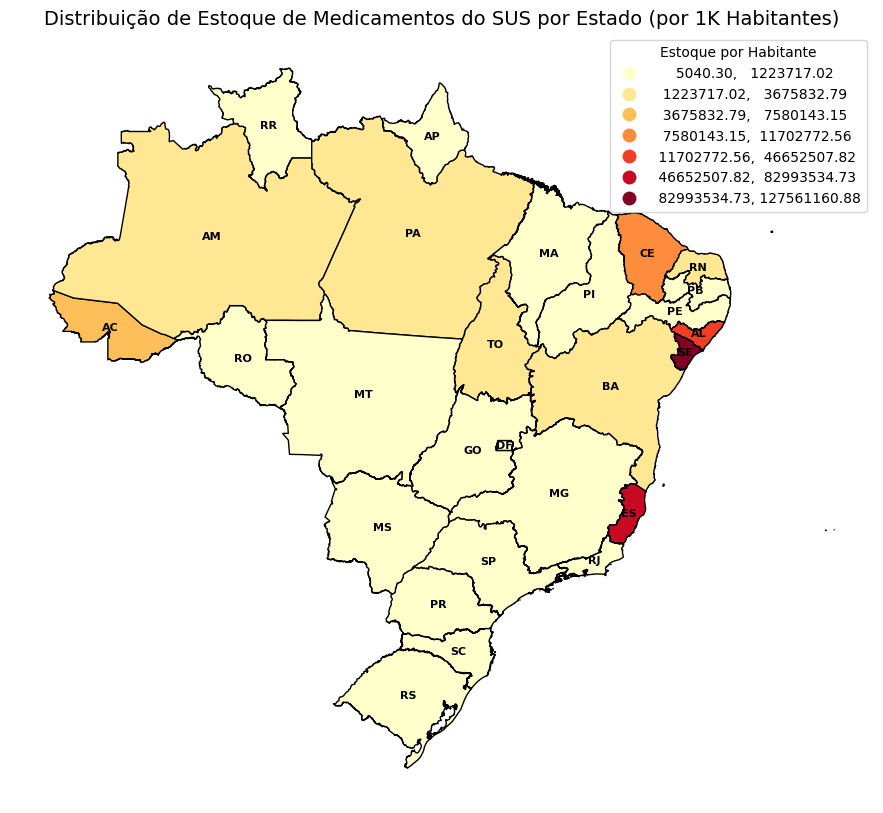

In [ ]:

# Lê geometrias dos estados do Brasil
gdf_brasil = read_state()  # retorna GeoDataFrame com geometria dos estados

# Junta df_uf
gdf_merged = gdf_brasil.merge(df_med_por_pop, left_on="abbrev_state", right_on="sg_uf")

# Plotagem estilo heatmap
gdf_merged.plot(
    column="med_por_hab",
    cmap="YlOrRd",
    legend=True,
    figsize=(15, 10),
    edgecolor="black",

    scheme="natural_breaks",  # ou "quantiles"
    k=7,                      # Número de classes (7 é um bom número)
    legend_kwds={
        'title': "Estoque por Habitante",
        'loc': 'upper right',
         'fmt': '{:.2f}'
    }
)

plt.title("Distribuição de Estoque de Medicamentos do SUS por Estado (por 1K Habitantes)", fontsize=14)
plt.axis("off")

for idx, row in gdf_merged.iterrows():
    plt.text(
        row.geometry.centroid.x,
        row.geometry.centroid.y,
        row["abbrev_state"],
        ha='center', va='center',
        fontsize=8, fontweight='bold', color='black'
    )

plt.show()